<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5410_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-30b2b4e07ac4>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_table(file_path, delim_whitespace=True, header=None)


Training with Dropout Rate: 0.3
Epoch 10/50, Loss: 0.8240
Epoch 20/50, Loss: 0.7522
Epoch 30/50, Loss: 0.6972
Epoch 40/50, Loss: 0.6765
Epoch 50/50, Loss: 0.6542


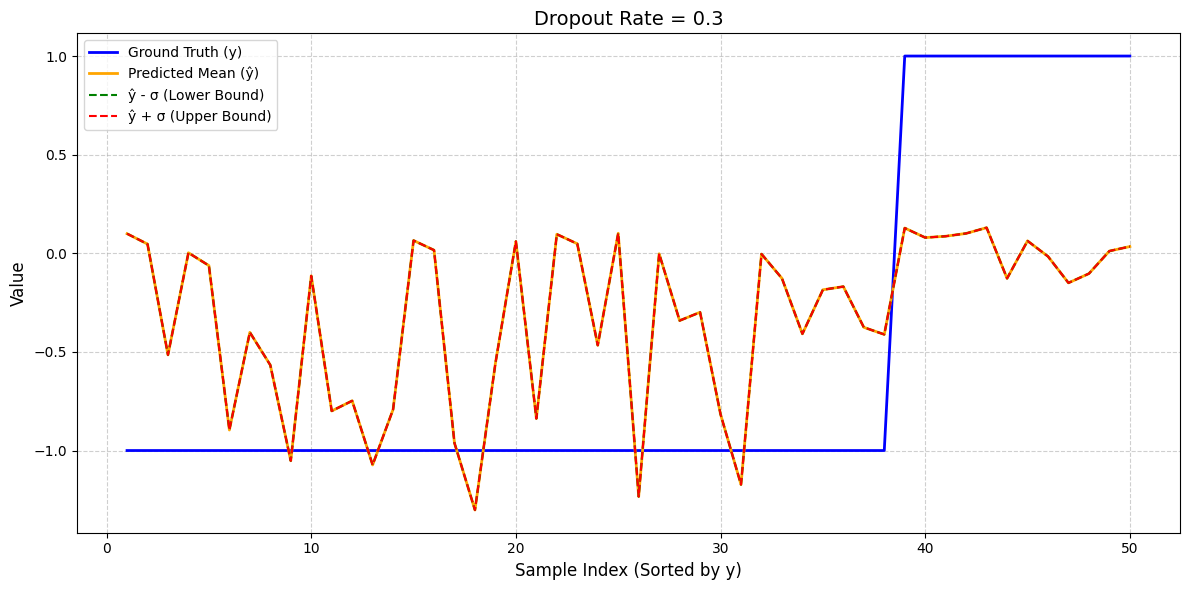

Training with Dropout Rate: 0.5
Epoch 10/50, Loss: 0.9243
Epoch 20/50, Loss: 0.8777
Epoch 30/50, Loss: 0.8463
Epoch 40/50, Loss: 0.7876
Epoch 50/50, Loss: 0.7345


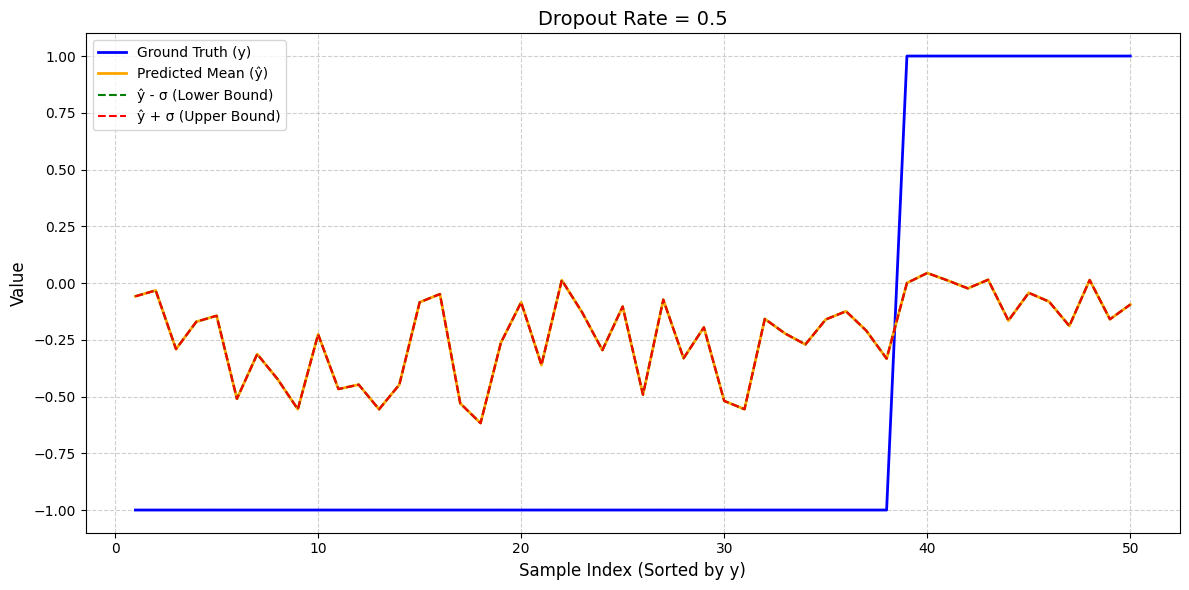

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount("/content/drive")

file_path = "/content/drive/My Drive/LibSVM-mpg.txt"
# Load the dataset using pandas
def load_data(file_path):
    # Read the space-delimited file
    # data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    data = pd.read_table(file_path, delim_whitespace=True, header=None)
    # data = np.loadtxt(file_path)

    # Check if the data has correct dimensions
    if data.shape[1] != 8:  # 7 features + 1 target = 8 columns
        raise ValueError(f"Expected 8 columns (7 features + 1 target), but got {data.shape[1]} columns.")

    X = data.iloc[:, :-1].values  # Features (first 7 columns)
    y = data.iloc[:, -1].values   # Target (last column)
   # y = data.iloc[:, 0].values   # Target (first column)
   # X = data.iloc[:, 1:].values  # Features (remaining columns)
    return X, y

# Define the MLP model with Dropout
class MLPWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the model
def train_model(model, X_train, y_train, epochs, lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Perform Monte-Carlo Dropout Testing
def monte_carlo_testing(model, X_test, num_passes):
    model.eval()  # Keep dropout active during testing
    X_test = torch.tensor(X_test, dtype=torch.float32)
    predictions = []

    for _ in range(num_passes):
        preds = model(X_test).detach().numpy()
        predictions.append(preds.reshape(-1))  # Flatten the predictions to ensure 1D consistency

    # Convert the list of 1D arrays to a 2D DataFrame
    predictions = pd.DataFrame(predictions)
    means = predictions.mean(axis=0).values
    stds = predictions.std(axis=0).values
    return means, stds

# Plot the results
def plot_results(y_true, y_mean, y_std, title):
    # Sort the data by true values for better visualization
    sorted_indices = pd.Series(y_true).sort_values().index
    y_true_sorted = pd.Series(y_true).iloc[sorted_indices]
    y_mean_sorted = pd.Series(y_mean).iloc[sorted_indices]
    y_std_sorted = pd.Series(y_std).iloc[sorted_indices]

    # Compute bounds
    lower_bound = y_mean_sorted - y_std_sorted  # Predicted Mean - Std
    upper_bound = y_mean_sorted + y_std_sorted  # Predicted Mean + Std

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(y_true_sorted) + 1), y_true_sorted, label="Ground Truth (y)", color="blue", linewidth=2)
    plt.plot(range(1, len(y_mean_sorted) + 1), y_mean_sorted, label="Predicted Mean (ŷ)", color="orange", linewidth=2)
    plt.plot(range(1, len(lower_bound) + 1), lower_bound, label="ŷ - σ (Lower Bound)", linestyle="--", color="green", linewidth=1.5)
    plt.plot(range(1, len(upper_bound) + 1), upper_bound, label="ŷ + σ (Upper Bound)", linestyle="--", color="red", linewidth=1.5)

    # Add labels, legend, and title
    plt.legend(loc="upper left", fontsize=10)
    plt.xlabel("Sample Index (Sorted by y)", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    try:
        # Load data
        X, y = load_data(file_path)

        # Split the dataset into training (342 samples) and testing (50 samples)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)

        # Normalize the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train and test for different dropout rates
        for dropout_rate in [0.3, 0.5]:
            print(f"Training with Dropout Rate: {dropout_rate}")
            model = MLPWithDropout(input_size=7, hidden_size=18, dropout_rate=dropout_rate)
            train_model(model, X_train, y_train, epochs=50, lr=0.001)

            # Perform Monte-Carlo Dropout Testing
            y_mean, y_std = monte_carlo_testing(model, X_test, num_passes=10)

            # Plot results
            plot_results(y_test, y_mean, y_std, title=f"Dropout Rate = {dropout_rate}")
    except Exception as e:
        print(f"Error: {e}")
